In [1]:
import os
from time import time
import errno
import shutil
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
## ensemble learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier  
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import IsolationForest
import seaborn as sns

import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
data_path = "./data/"

# LFS dataset from path
lfw = fetch_lfw_people(min_faces_per_person=70, resize=0.4, data_home=data_path)


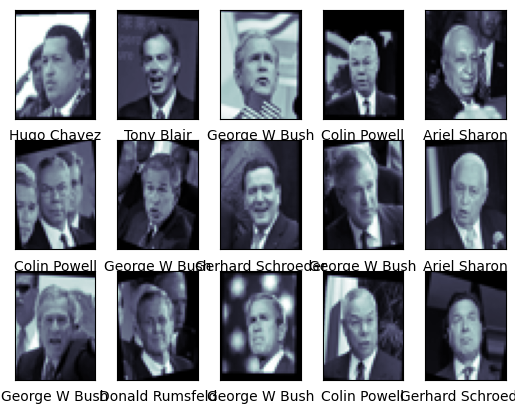

In [3]:
## visualize the data
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(lfw.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=lfw.target_names[lfw.target[i]])

In [4]:
lfw_people = lfw.copy()
lfw_people.keys()

dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])

In [5]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people['images'].shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people['data']
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people['target']
target_names = lfw_people['target_names']
n_classes = lfw_people['target_names'].shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [6]:
#  split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25)

In [7]:
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled  
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
        % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
            whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 966 faces
done in 0.333s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.024s


## ENSEMBLE METHODS

In [8]:
## ensemble methods
model_names = ['RandomForestClassifier', 'AdaBoostClassifier', 'GradientBoostingClassifier', 'BaggingClassifier']
model_list = [RandomForestClassifier(), AdaBoostClassifier(), GradientBoostingClassifier(), BaggingClassifier()]
## results dictionary
results = {}

## loop through models
for model_name, model in zip(model_names, model_list):
    print(model_name)
    t0 = time()
    model.fit(X_train_pca, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)
    
    t0 = time()
    y_pred = model.predict(X_test_pca)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)
    
    score = accuracy_score(y_test, y_pred)
    print("accuracy:   %0.3f" % score)

    print()
    
    results[model_name] = [train_time, test_time, score]




RandomForestClassifier
train time: 0.983s
test time:  0.018s
accuracy:   0.453

AdaBoostClassifier
train time: 1.068s
test time:  0.017s
accuracy:   0.357

GradientBoostingClassifier
train time: 34.787s
test time:  0.016s
accuracy:   0.590

BaggingClassifier
train time: 1.209s
test time:  0.003s
accuracy:   0.453



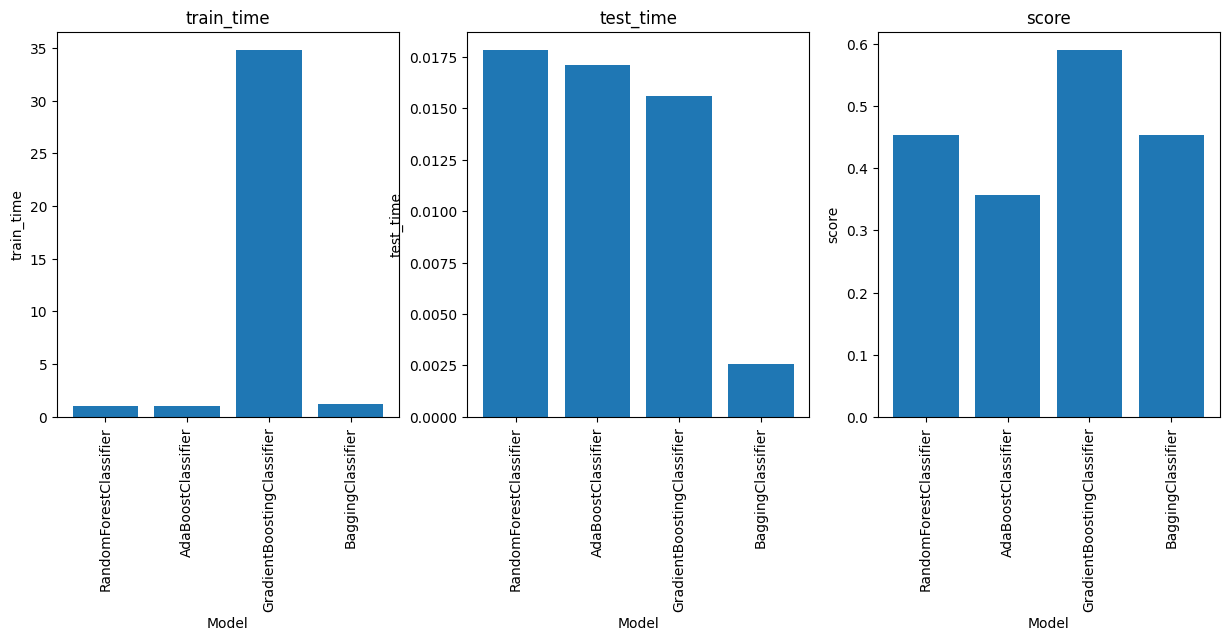

In [9]:
## plot results
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, metric in enumerate(['train_time', 'test_time', 'score']):
    ax[i].bar(results.keys(), [results[k][i] for k in results.keys()])
    ax[i].set_title(metric) 
    ax[i].set_xticklabels(results.keys(), rotation=90)
    # title
    ax[i].set_title(metric)
    # x-axis label
    ax[i].set_xlabel('Model', fontsize=10)
    # y-axis label
    ax[i].set_ylabel(metric, fontsize=10)

plt.show()

RandomForestClassifier
[[  0   0   0  23   0   0   0]
 [  0  14   0  50   0   0   0]
 [  0   1   0  24   0   0   0]
 [  0   0   0 131   0   0   0]
 [  0   0   0  19   0   0   0]
 [  0   1   0  17   0   0   0]
 [  0   1   0  40   0   0   1]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.82      0.22      0.35        64
           2       0.00      0.00      0.00        25
           3       0.43      1.00      0.60       131
           4       0.00      0.00      0.00        19
           5       0.00      0.00      0.00        18
           6       1.00      0.02      0.05        42

    accuracy                           0.45       322
   macro avg       0.32      0.18      0.14       322
weighted avg       0.47      0.45      0.32       322

AdaBoostClassifier
[[ 5  4  2 10  1  0  1]
 [ 3 15  4 26  3  4  9]
 [ 1  8  5  3  1  1  6]
 [ 3 16 11 80 10  1 10]
 [ 0  0  2 11  4  0  2]
 [ 0  3  0 11  1  2  1]

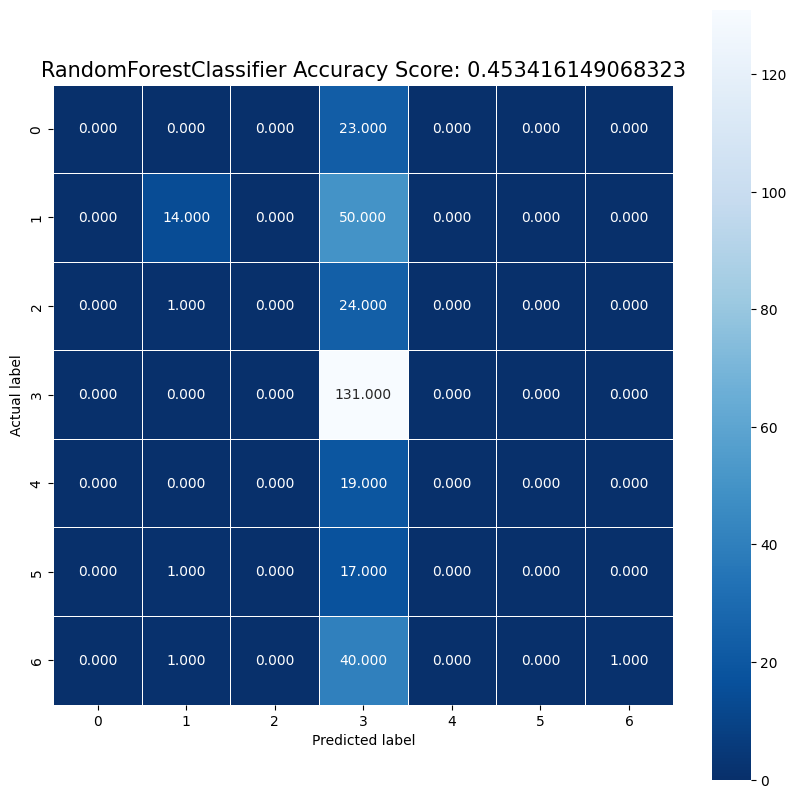

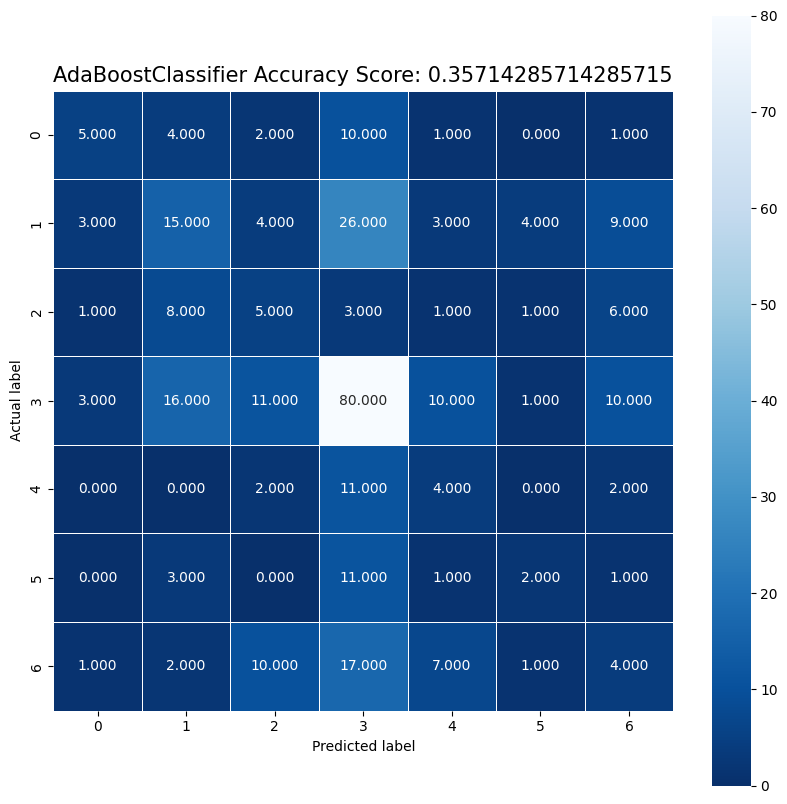

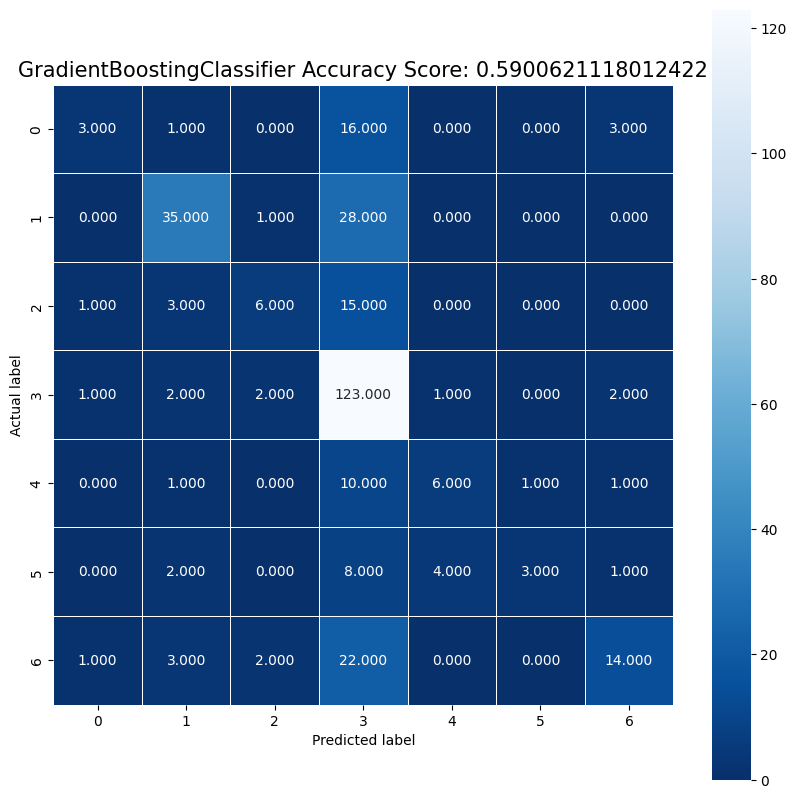

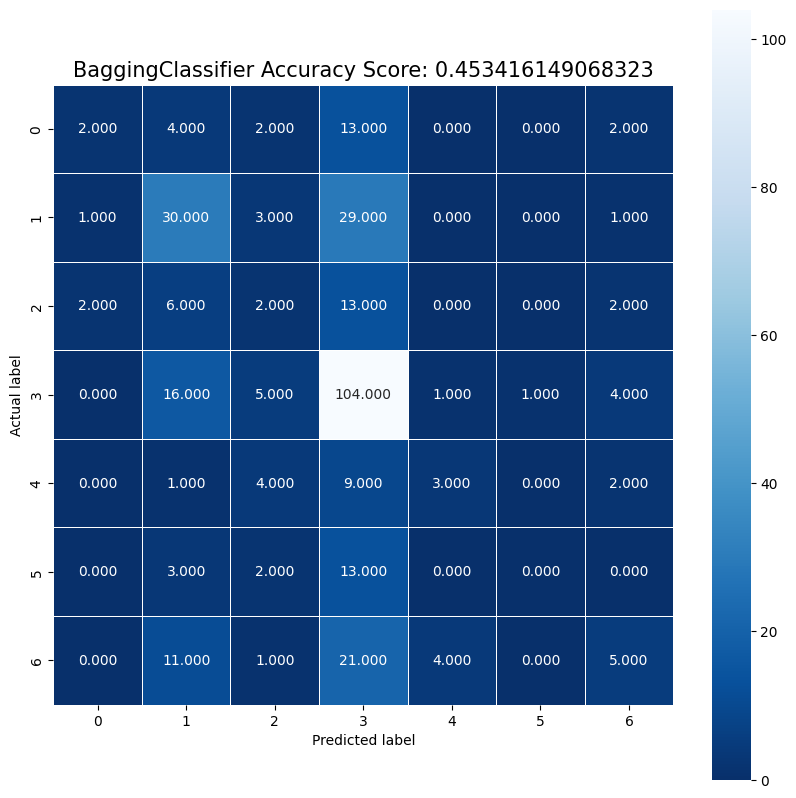

In [10]:
## plot confusion matrix for evry model
for model_name, model in zip(model_names, model_list):
    y_pred = model.predict(X_test_pca)
    cm = confusion_matrix(y_test, y_pred)
    print(model_name)
    print(cm)
    print(classification_report(y_test, y_pred))
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test, y_pred))
    plt.title(model_name + " " + all_sample_title, size = 15);



In [11]:
## metrics for evry model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
for model_name, model in zip(model_names, model_list):
    y_pred = model.predict(X_test_pca)
    print(model_name)
    print("accuracy:   %0.3f" % accuracy_score(y_test, y_pred))
    print("precision:   %0.3f" % precision_score(y_test, y_pred, average='weighted'))
    print("recall:   %0.3f" % recall_score(y_test, y_pred, average='weighted'))
    print("f1:   %0.3f" % f1_score(y_test, y_pred, average='weighted'))
    print()



RandomForestClassifier
accuracy:   0.453
precision:   0.469
recall:   0.453
f1:   0.320

AdaBoostClassifier
accuracy:   0.357
precision:   0.344
recall:   0.357
f1:   0.344

GradientBoostingClassifier
accuracy:   0.590
precision:   0.613
recall:   0.590
f1:   0.546

BaggingClassifier
accuracy:   0.453
precision:   0.393
recall:   0.453
f1:   0.395

